# Imports

In [ ]:
import os
from google.colab import drive
import pandas as pd
import zipfile
import re
import matplotlib.pyplot as plt
from matplotlib import image
from plotnine import *
import random
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt 
import random
from tensorflow import keras
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, array_to_img
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.6 MB/s 


In [ ]:
drive.mount('/content/drive',force_remount=True) 
os.chdir('/content/drive/MyDrive/Deep2')

Mounted at /content/drive


In [ ]:
#!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'

In [ ]:
with zipfile.ZipFile('MURA-v1.1.zip', 'r') as zip_ref:
  zip_ref.extractall()

#Paths

##Train Paths

In [ ]:
train_paths = pd.read_csv( "MURA-v1.1/train_image_paths.csv", names=["image_path"], header=None, index_col=False)
train_paths["type"] = train_paths["image_path"].map(lambda x: x.split("/")[2])
train_paths["patient"] = train_paths["image_path"].map(lambda x: x.split("/")[3][7:])
train_paths["study"] = train_paths["image_path"].map(lambda x: x.split("/")[4])
train_paths["path"] = train_paths["image_path"].map(lambda x: '/'.join(x.split('/')[:-1]))

In [ ]:
train_paths

,image_path,type,patient,study,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,00002,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,00002,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...,...,...,...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,XR_HAND,11183,study1_negative,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,XR_HAND,11183,study1_negative,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,XR_HAND,11184,study1_negative,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,XR_HAND,11184,study1_negative,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


In [ ]:
train_labels = pd.read_csv("MURA-v1.1/train_labeled_studies.csv",names=["path", "label"],header=None,index_col=False)
train_labels['path']=train_labels['path'].map(lambda x:x[:-1])
train_labels["label"] = train_labels["label"].map(str)

In [ ]:
train_labels

,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1
...,...,...
13452,MURA-v1.1/train/XR_HAND/patient11180/study1_ne...,0
13453,MURA-v1.1/train/XR_HAND/patient11181/study1_ne...,0
13454,MURA-v1.1/train/XR_HAND/patient11182/study1_ne...,0
13455,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0


In [ ]:
train_data = pd.merge(train_paths, train_labels, how="inner", on="path")

In [ ]:
train_data

,image_path,type,patient,study,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,00002,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,00002,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
...,...,...,...,...,...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,XR_HAND,11183,study1_negative,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,XR_HAND,11183,study1_negative,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,XR_HAND,11184,study1_negative,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,0
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,XR_HAND,11184,study1_negative,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,0


##Test Paths

In [ ]:
test_paths = pd.read_csv( "MURA-v1.1/valid_image_paths.csv", names=["image_path"], header=None, index_col=False)
test_paths["type"] = test_paths["image_path"].map(lambda x: x.split("/")[2])
test_paths["patient"] = test_paths["image_path"].map(lambda x: x.split("/")[3][7:])
test_paths["study"] = test_paths["image_path"].map(lambda x: x.split("/")[4])
test_paths["path"] = test_paths["image_path"].map(lambda x: '/'.join(x.split('/')[:-1]))

In [ ]:
test_paths

,image_path,type,patient,study,path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,11186,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...
...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,11967,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,11967,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,11738,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,11738,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...


In [ ]:
test_labels = pd.read_csv(os.path.join("MURA-v1.1/valid_labeled_studies.csv"),names=["path", "label"],header=None,index_col=False)
test_labels['path']=test_labels['path'].map(lambda x:x[:-1])
test_labels["label"] = test_labels["label"].map(str)

In [ ]:
test_labels

,path,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1
...,...,...
1194,MURA-v1.1/valid/XR_FINGER/patient11965/study1_...,0
1195,MURA-v1.1/valid/XR_FINGER/patient11855/study1_...,0
1196,MURA-v1.1/valid/XR_FINGER/patient11966/study1_...,0
1197,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,0


In [ ]:
test_data = pd.merge(test_paths, test_labels, how="inner", on="path")

In [ ]:
test_data

,image_path,type,patient,study,path,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,11186,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,11967,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,11967,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,11738,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,11738,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,0


#Data Analysis

In [ ]:
counts=pd.DataFrame(train_labels["label"].value_counts())

Text(0.5, 1.0, 'Count of normal-abnormal X-rays')

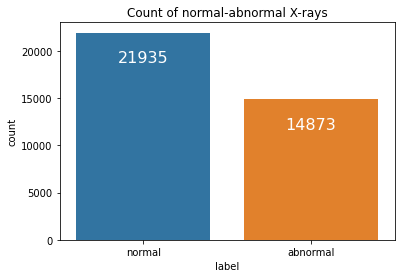

In [ ]:
import seaborn as sns
ax=sns.countplot(data=train_data,x='label')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.25, p.get_height()), ha='left', va='top', color='white', size=16)
ax.set_xticklabels(('normal','abnormal'))
plt.title('Count of normal-abnormal X-rays')

Text(0.5, 1.0, 'Count of X-rays per bodypart')

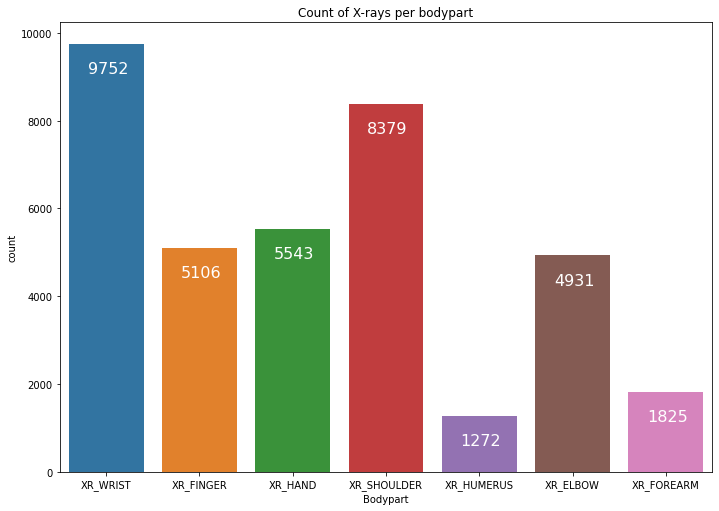

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(data=train_data,x='type')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='left', va='top', color='white', size=16)
plt.xlabel('Bodypart')
plt.title('Count of X-rays per bodypart')

Text(0.5, 1.0, 'Count of normal-abnormal X-rays per bodypart')

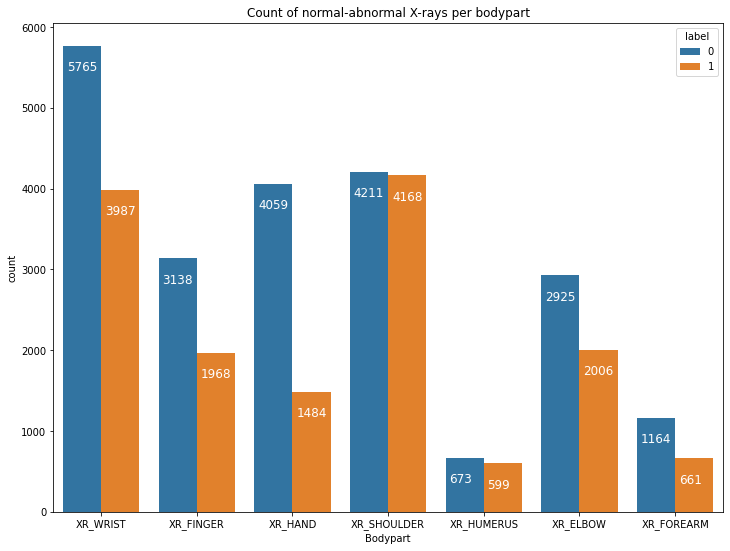

In [ ]:
a4_dims = (12,9)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(data=train_data,x='type',hue='label')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.04, p.get_height()), ha='left', va='top', color='white', size=12)
plt.xlabel('Bodypart')
plt.title('Count of normal-abnormal X-rays per bodypart')

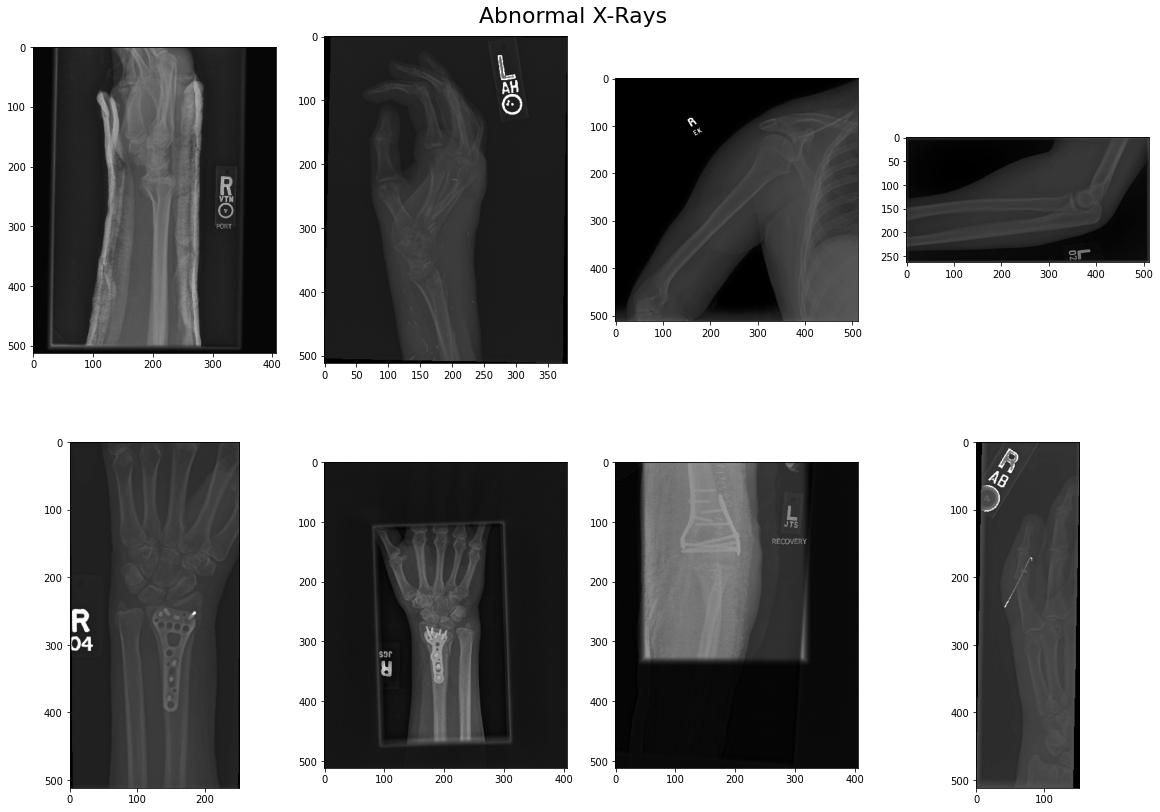

In [ ]:
abnormal=train_data.image_path[train_data.label=='1'][:8]
ax = []
fig = plt.figure(figsize=(20, 14))
for i,path in enumerate(abnormal):
      ax.append(fig.add_subplot(2, 4,i+1))
      img = image.imread(path)
      plt.imshow(img, cmap="gray")
fig.suptitle('Abnormal X-Rays',fontsize=22,y=0.9)
plt.show()

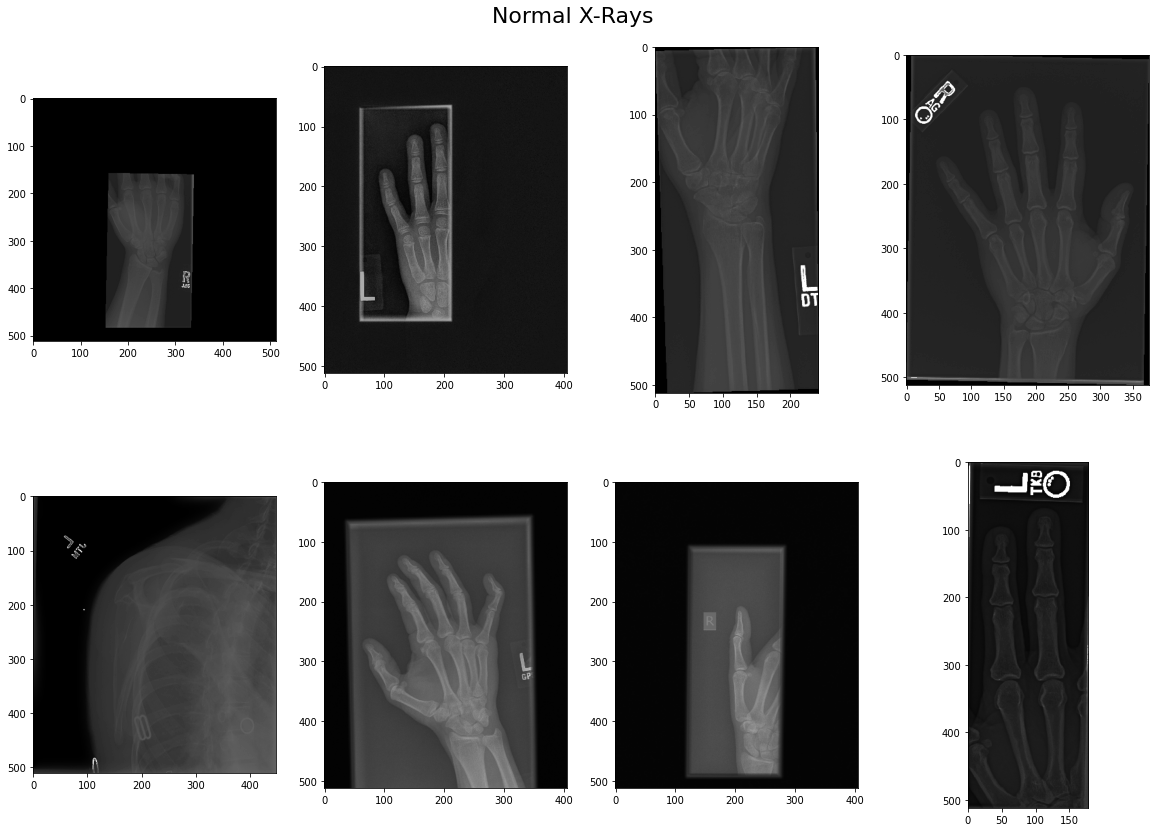

In [ ]:
normal=train_data.image_path[train_data.label=='0'][:8]
ax = []
fig = plt.figure(figsize=(20, 14))
for i,path in enumerate(normal):
      ax.append(fig.add_subplot(2, 4,i+1))
      img = image.imread(path)
      plt.imshow(img, cmap="gray")
fig.suptitle('Normal X-Rays',fontsize=22,y=0.92)
plt.show()

#Image Data Generator

##For Train-Validation Set

In [ ]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30,
                                                            horizontal_flip=True,
                                                            fill_mode="constant",
                                                            cval=0.0,
                                                            rescale=1.0 / 255,
                                                            validation_split=0.2)

In [ ]:
image_width= 224
image_height = 224
train_data = shuffle(train_data, random_state=2022)

In [ ]:
train= image_gen.flow_from_dataframe(dataframe=train_data,
                                     x_col="image_path",
                                     y_col="label",
                                     target_size=(image_width, image_height),
                                     class_mode="binary",
                                     batch_size=32,
                                     seed=2022,
                                     shuffle=True,
                                     subset="training")

Found 29447 validated image filenames belonging to 2 classes.


In [ ]:
val = image_gen.flow_from_dataframe(dataframe=train_data,
                                    x_col="image_path",
                                    y_col="label",
                                    target_size=(image_width, image_height),
                                    class_mode="binary",
                                    batch_size=32,
                                    seed=2022,
                                    shuffle=False,
                                    subset="validation")

Found 7361 validated image filenames belonging to 2 classes.


##For Test Set

In [ ]:
image_gen_cnn = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

In [ ]:
test = image_gen_cnn.flow_from_dataframe(dataframe=test_data,
                                         x_col="image_path",
                                         y_col="label",
                                         target_size=(image_width, image_height),
                                         class_mode="binary",
                                         batch_size=32,
                                         seed=2022,
                                         shuffle=False)  # this is very important in order to properly use raw predictions to evaluate on study-level!

Found 3197 validated image filenames belonging to 2 classes.


#CNN

In [ ]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name="binary_acc"), tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2)]

In [ ]:
def CNN_model():

    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters = 16,kernel_size=(3,3),padding='same',activation='relu',input_shape=(image_width, image_height,3)))
    model.add(BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(filters = 32,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(filters = 64,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(keras.layers.Dropout(0.25))


    model.add(keras.layers.Conv2D(filters = 64,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(units=128,activation="relu"))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Dense(units=1, activation="sigmoid"))


    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=Metrics)
    
    return model

In [ ]:
model=CNN_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     1

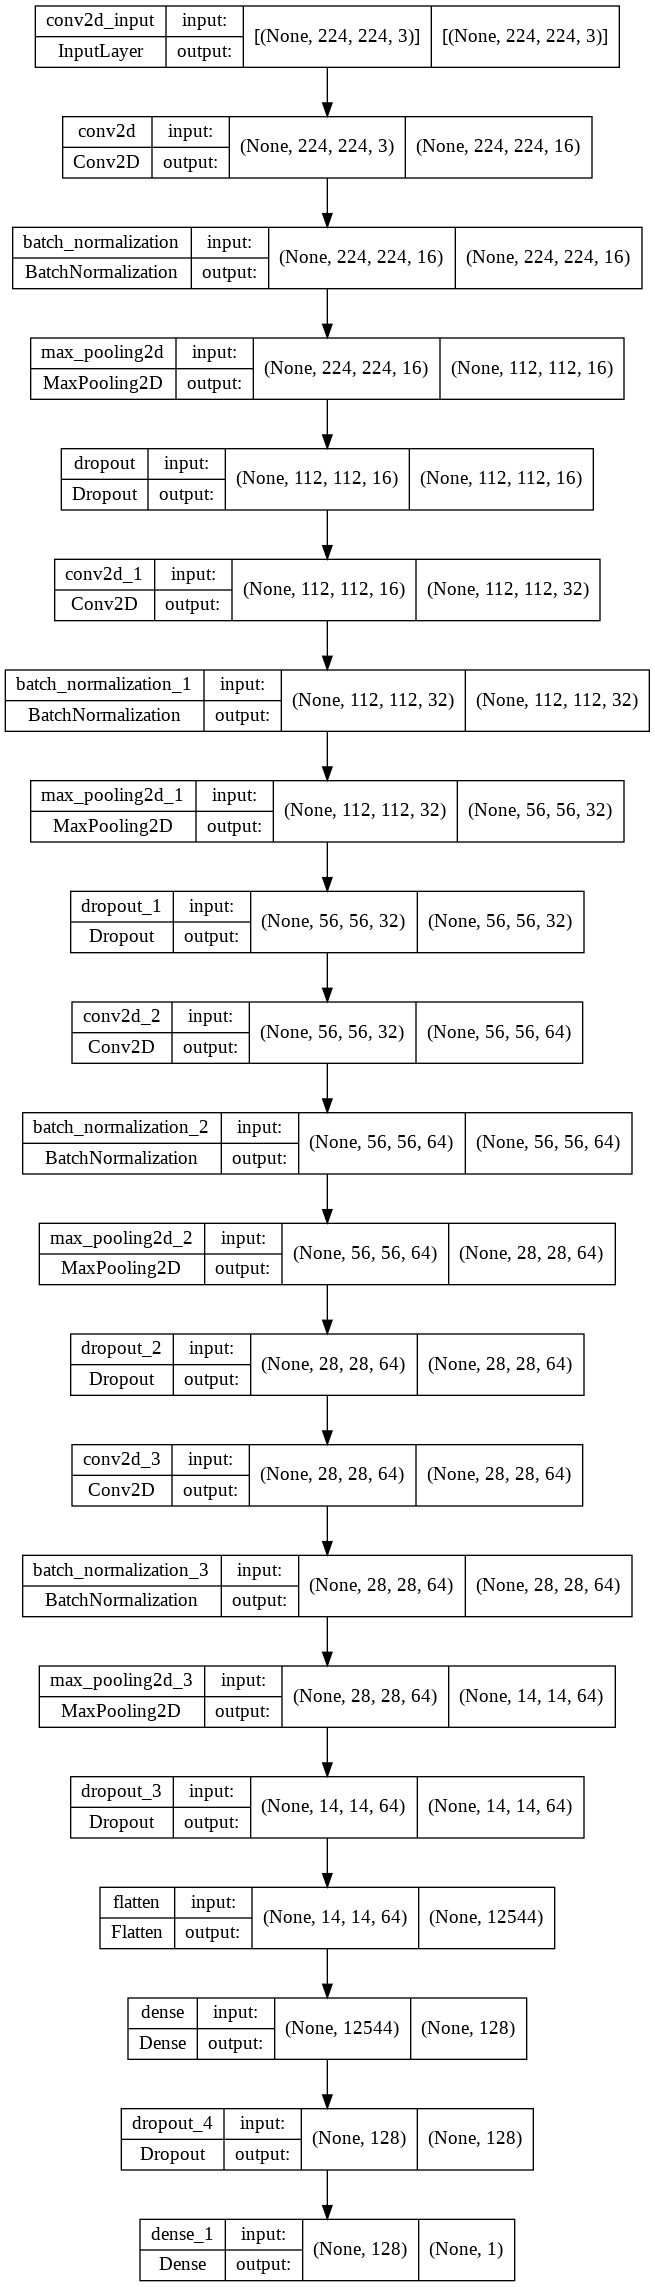

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_cohen_kappa",patience=5,mode="max",restore_best_weights=True)

In [ ]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_cohen_kappa",verbose=1,patience=4,mode="max",factor=0.2,min_lr=1e-6)

In [ ]:
history = model.fit(train, epochs=50, validation_data=val, callbacks=[early_stopping, reduce_lr_on_plateau], workers=8)

In [ ]:
plt.style.use("bmh")

In [ ]:
kappa = history.history['cohen_kappa']
val_kappa = history.history['val_cohen_kappa']
loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs = range(len(kappa))

plt.figure(figsize = (7,8))

plt.plot(epochs, kappa, 'cyan', label='Training kappa')
plt.plot(epochs, val_kappa, 'plum', label='Validation kappa')
plt.title('Training and validation kappa')
plt.legend()

plt.figure()

plt.figure(figsize = (7,8))

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'plum', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/CNNmodel')

In [ ]:
pred=model.predict(test)
pred=np.round(pred)
pred=pd.DataFrame(pred).astype('int')
pred=pred.astype('str')

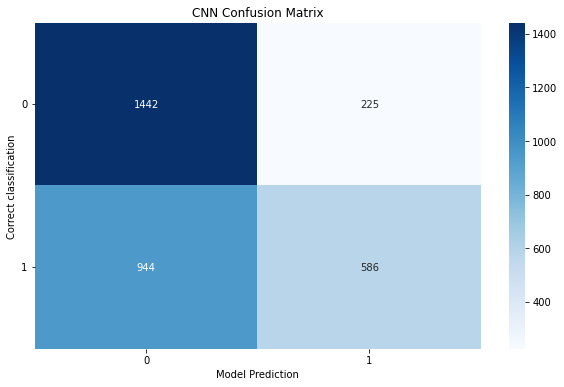

In [ ]:
mat_aug = confusion_matrix(test_data.label, pred)
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_aug, annot=True, fmt='g', cmap = 'Blues')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('CNN Confusion Matrix')
ax.xaxis.set_ticklabels([i for i in range(0,2)])
ax.yaxis.set_ticklabels([i for i in range(0,2)])
plt.yticks(rotation=0)
plt.show()

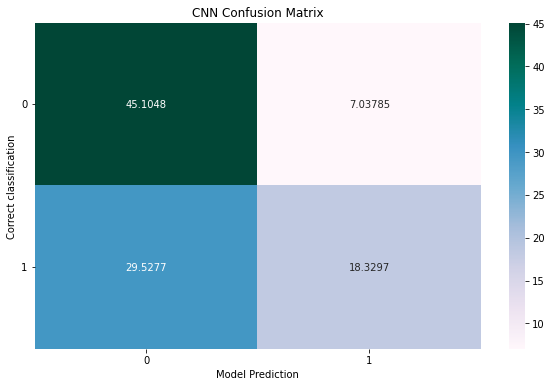

In [ ]:
mat_perc = 100*(mat_aug / len(test_data))
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_perc, annot=True, fmt='g', cmap = 'PuBuGn')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('CNN Confusion Matrix')
ax.xaxis.set_ticklabels([i for i in range(0,2)])
ax.yaxis.set_ticklabels([i for i in range(0,2)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print(classification_report(test_data.label, pred))

              precision    recall  f1-score   support

           0       0.60      0.87      0.71      1667
           1       0.72      0.38      0.50      1530

    accuracy                           0.63      3197
   macro avg       0.66      0.62      0.61      3197
weighted avg       0.66      0.63      0.61      3197



In [ ]:
wrist_test=test_data[test_data['type']=='XR_WRIST']
wrist_pred=pred[test_data['type']=='XR_WRIST']

shoulder_test=test_data[test_data['type']=='XR_SHOULDER']
shoulder_pred=pred[test_data['type']=='XR_SHOULDER']

elbow_test=test_data[test_data['type']=='XR_ELBOW']
elbow_pred=pred[test_data['type']=='XR_ELBOW']

finger_test=test_data[test_data['type']=='XR_FINGER']
finger_pred=pred[test_data['type']=='XR_FINGER']

hand_test=test_data[test_data['type']=='XR_HAND']
hand_pred=pred[test_data['type']=='XR_HAND']

forearm_test=test_data[test_data['type']=='XR_FOREARM']
forearm_pred=pred[test_data['type']=='XR_FOREARM']

humerus_test=test_data[test_data['type']=='XR_HUMERUS']
humerus_pred=pred[test_data['type']=='XR_HUMERUS']

In [ ]:
print('Cohen kappa score for all body-parts:',round(cohen_kappa_score(test_data.label,pred),2))

Cohen kappa score for all body-parts: 0.25


In [ ]:
print('Cohen kappa score for wrist:',round(cohen_kappa_score(wrist_test.label,wrist_pred),2))
print('Cohen kappa score for shoulder:',round(cohen_kappa_score(shoulder_test.label,shoulder_pred),2))
print('Cohen kappa score for elbow:',round(cohen_kappa_score(elbow_test.label,elbow_pred),2))
print('Cohen kappa score for finger:',round(cohen_kappa_score(finger_test.label,finger_pred),2))
print('Cohen kappa score for hand:',round(cohen_kappa_score(hand_test.label,hand_pred),2))
print('Cohen kappa score for forearm:',round(cohen_kappa_score(forearm_test.label,forearm_pred),2))
print('Cohen kappa score for humerus:',round(cohen_kappa_score(humerus_test.label,humerus_pred),2))

Cohen kappa score for wrist: 0.34
Cohen kappa score for shoulder: 0.23
Cohen kappa score for elbow: 0.37
Cohen kappa score for finger: 0.16
Cohen kappa score for hand: 0.13
Cohen kappa score for forearm: 0.35
Cohen kappa score for humerus: 0.1


#ResNet 50


In [ ]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30,
                                                            horizontal_flip=True,
                                                            fill_mode="constant",
                                                            cval=0.0,
                                                            validation_split=0.2,
                                                            preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
image_width= 224
image_height = 224
train_data = shuffle(train_data, random_state=2022)

In [ ]:
train= image_gen.flow_from_dataframe(dataframe=train_data,
                                     x_col="image_path",
                                     y_col="label",
                                     target_size=(image_width, image_height),
                                     class_mode="binary",
                                     batch_size=8,
                                     seed=2022,
                                     shuffle=True,
                                     subset="training")

Found 29447 validated image filenames belonging to 2 classes.


In [ ]:
val = image_gen.flow_from_dataframe(dataframe=train_data,
                                    x_col="image_path",
                                    y_col="label",
                                    target_size=(image_width, image_height),
                                    class_mode="binary",
                                    batch_size=8,
                                    seed=2022,
                                    shuffle=False,
                                    subset="validation")

Found 7361 validated image filenames belonging to 2 classes.


In [ ]:
image_gen_res50 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
test = image_gen_res50.flow_from_dataframe(dataframe=test_data,
                                           x_col="image_path",
                                           y_col="label",
                                           target_size=(image_width, image_height),
                                           class_mode="binary",
                                           batch_size=32,
                                           seed=2022,
                                           shuffle=False)  # this is very important in order to properly use raw predictions to evaluate on study-level!

Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
model_res= tf.keras.applications.resnet50.ResNet50(include_top=False,  # do not include the fully-connected layer at the top of the network
                                                   weights="imagenet",
                                                   input_shape=(image_width, image_height, 3),
                                                   pooling="max",  # pooling mode for feature extraction
                                                   classes=2)

In [ ]:
model_res.trainable = False

inputs = tf.keras.Input(shape=(image_width, image_height, 3))
x = model_res(inputs, training=False)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x= Dense(1024,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, output)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=Metrics)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

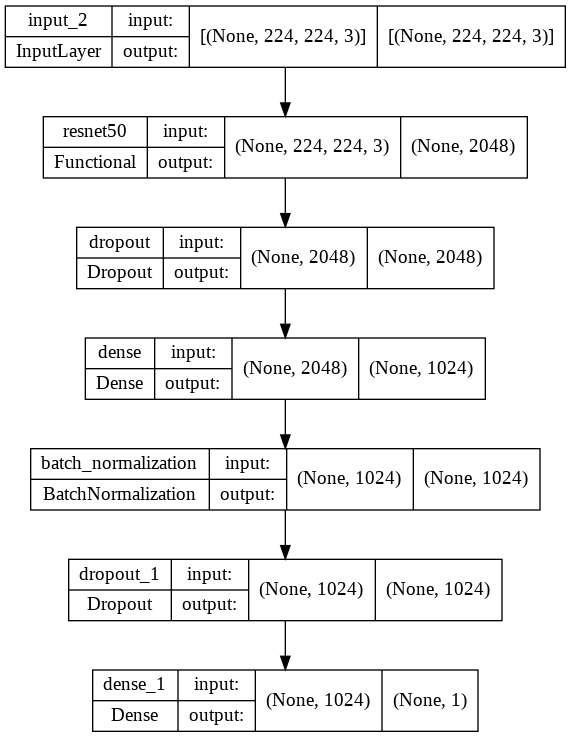

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_cohen_kappa",
                                                  verbose=1,
                                                  patience=5,
                                                  mode="max",
                                                  baseline=0.0,
                                                  restore_best_weights=True)

In [ ]:
history = model.fit(train,
                    epochs=12,
                    validation_data=val,
                    callbacks=[early_stopping],
                    workers=8)

Epoch 1/12
3681/3681 [==============================] - 526s 138ms/step - loss: 0.6920 - binary_acc: 0.6484 - cohen_kappa: 0.2607 - val_loss: 0.6129 - val_binary_acc: 0.6744 - val_cohen_kappa: 0.3531
Epoch 2/12
3681/3681 [==============================] - 514s 139ms/step - loss: 0.6204 - binary_acc: 0.6803 - cohen_kappa: 0.3211 - val_loss: 0.5581 - val_binary_acc: 0.7215 - val_cohen_kappa: 0.3979
Epoch 3/12
3681/3681 [==============================] - 516s 140ms/step - loss: 0.5934 - binary_acc: 0.6911 - cohen_kappa: 0.3394 - val_loss: 0.5529 - val_binary_acc: 0.7223 - val_cohen_kappa: 0.4144
Epoch 4/12
3681/3681 [==============================] - 515s 140ms/step - loss: 0.5822 - binary_acc: 0.6984 - cohen_kappa: 0.3529 - val_loss: 0.5540 - val_binary_acc: 0.7229 - val_cohen_kappa: 0.3865
Epoch 5/12
3681/3681 [==============================] - 508s 138ms/step - loss: 0.5756 - binary_acc: 0.7033 - cohen_kappa: 0.3612 - val_loss: 0.5497 - val_binary_acc: 0.7256 - val_cohen_kappa: 0.4118


In [ ]:
#model.save('/content/drive/MyDrive/Lastmodel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Lastmodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Lastmodel/assets


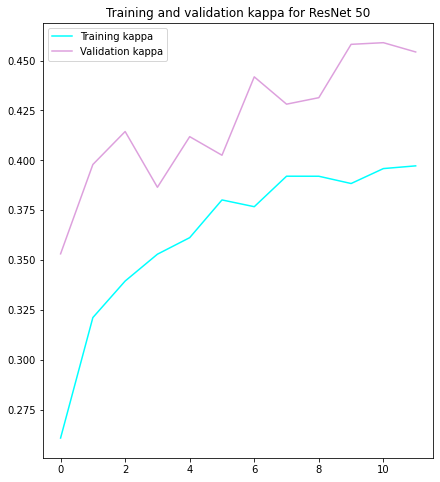

<Figure size 432x288 with 0 Axes>

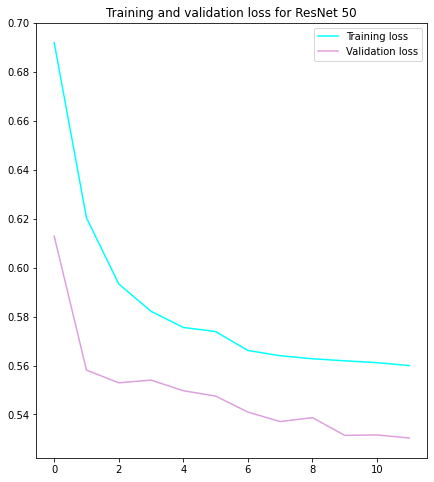

In [ ]:
kappa = history.history['cohen_kappa']
val_kappa = history.history['val_cohen_kappa']
loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs = range(len(kappa))

plt.figure(figsize = (7,8))

plt.plot(epochs, kappa, 'cyan', label='Training kappa')
plt.plot(epochs, val_kappa, 'plum', label='Validation kappa')
plt.title('Training and validation kappa for ResNet 50')
plt.legend()

plt.figure()

plt.figure(figsize = (7,8))

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'plum', label='Validation loss')
plt.title('Training and validation loss for ResNet 50')
plt.legend()

plt.show()

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/Lastmodel')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

In [ ]:
model.evaluate(test,verbose=1)

100/100 [==============================] - 30s 239ms/step - loss: 0.5494 - binary_acc: 0.7329 - cohen_kappa: 0.4592


[0.549382209777832, 0.7328745722770691, 0.4592180848121643]

In [ ]:
pred=model.predict(test)
pred=np.round(pred)
pred=pd.DataFrame(pred).astype('int')
pred=pred.astype('str')

In [ ]:
print(classification_report(test_data.label, pred))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77      1667
           1       0.79      0.60      0.68      1530

    accuracy                           0.73      3197
   macro avg       0.75      0.73      0.73      3197
weighted avg       0.74      0.73      0.73      3197



In [ ]:
for i in range(7):
  print(i)
  model.layers[i].trainable=True

0
1
2
3
4
5
6


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.BinaryCrossentropy(),metrics=Metrics)

In [ ]:
history = model.fit(train,
                    epochs=15,
                    validation_data=val,
                    callbacks=[early_stopping, tf.keras.callbacks.ReduceLROnPlateau(
                        monitor='val_cohen_kappa',
                        factor=0.1,
                        patience=8,
                        min_lr=1e-9)],
                    workers=8)

Epoch 1/15
3681/3681 [==============================] - 611s 163ms/step - loss: 0.5509 - binary_acc: 0.7270 - cohen_kappa: 0.4124 - val_loss: 0.4943 - val_binary_acc: 0.7738 - val_cohen_kappa: 0.5125 - lr: 1.0000e-05
Epoch 2/15
3681/3681 [==============================] - 584s 159ms/step - loss: 0.5168 - binary_acc: 0.7551 - cohen_kappa: 0.4741 - val_loss: 0.4932 - val_binary_acc: 0.7768 - val_cohen_kappa: 0.5117 - lr: 1.0000e-05
Epoch 3/15
3681/3681 [==============================] - 590s 160ms/step - loss: 0.5101 - binary_acc: 0.7604 - cohen_kappa: 0.4853 - val_loss: 0.4912 - val_binary_acc: 0.7811 - val_cohen_kappa: 0.5268 - lr: 1.0000e-05
Epoch 4/15
3681/3681 [==============================] - 588s 160ms/step - loss: 0.4970 - binary_acc: 0.7723 - cohen_kappa: 0.5125 - val_loss: 0.4917 - val_binary_acc: 0.7761 - val_cohen_kappa: 0.5425 - lr: 1.0000e-05
Epoch 5/15
3681/3681 [==============================] - 577s 157ms/step - loss: 0.4869 - binary_acc: 0.7774 - cohen_kappa: 0.5241 - 

In [ ]:
model.save('/content/drive/MyDrive/ResnetUltraLast')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ResnetUltraLast/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ResnetUltraLast/assets


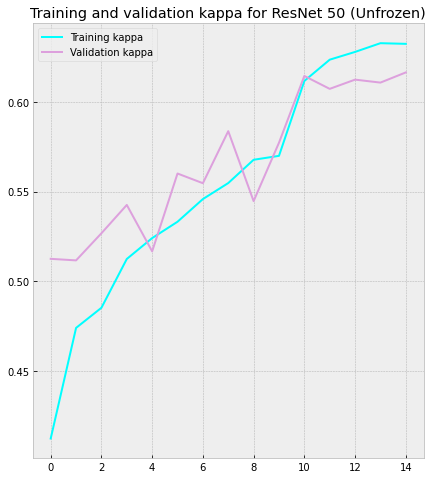

<Figure size 432x288 with 0 Axes>

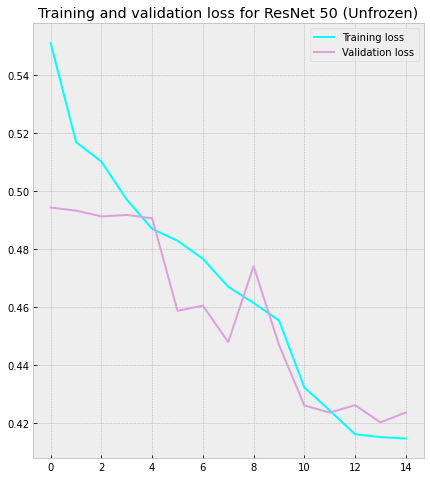

In [ ]:
plt.style.use("bmh")
kappa = history.history['cohen_kappa']
val_kappa = history.history['val_cohen_kappa']
loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs = range(len(kappa))

plt.figure(figsize = (7,8))

plt.plot(epochs, kappa, 'cyan', label='Training kappa')
plt.plot(epochs, val_kappa, 'plum', label='Validation kappa')
plt.title('Training and validation kappa for ResNet 50 (Unfrozen)')
plt.legend()

plt.figure()

plt.figure(figsize = (7,8))

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'plum', label='Validation loss')
plt.title('Training and validation loss for ResNet 50 (Unfrozen)')
plt.legend()

plt.show()

In [ ]:
model.evaluate(test,verbose=1)

100/100 [==============================] - 28s 273ms/step - loss: 0.4775 - binary_acc: 0.8051 - cohen_kappa: 0.6056


[0.47745898365974426, 0.8051298260688782, 0.6055915355682373]

In [ ]:
pred=model.predict(test)
pred=np.round(pred)
pred=pd.DataFrame(pred).astype('int')
pred=pred.astype('str')

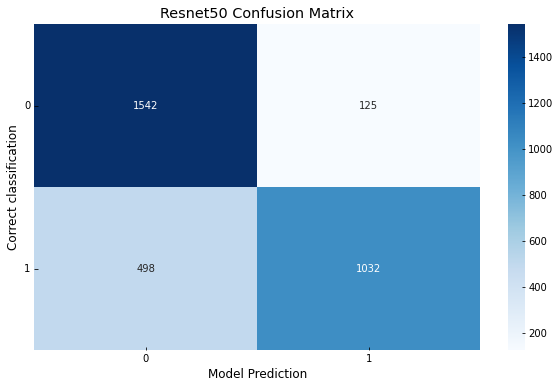

In [ ]:
mat_aug = confusion_matrix(test_data.label, pred)
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_aug, annot=True, fmt='g', cmap = 'Blues')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('Resnet50 Confusion Matrix')
ax.xaxis.set_ticklabels([i for i in range(0,2)])
ax.yaxis.set_ticklabels([i for i in range(0,2)])
plt.yticks(rotation=0)
plt.show()

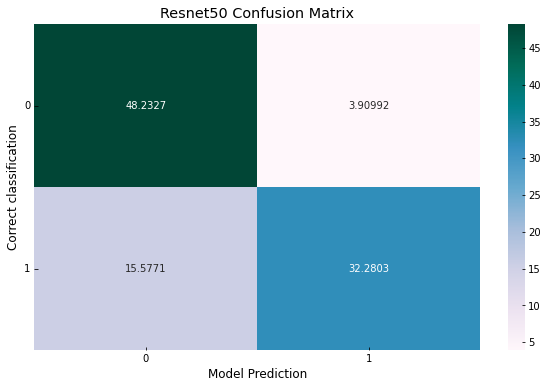

In [ ]:
mat_perc = 100*(mat_aug / len(test_data))
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_perc, annot=True, fmt='g', cmap = 'PuBuGn')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('Resnet50 Confusion Matrix')
ax.xaxis.set_ticklabels([i for i in range(0,2)])
ax.yaxis.set_ticklabels([i for i in range(0,2)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print(classification_report(test_data.label, pred))

              precision    recall  f1-score   support

           0       0.76      0.93      0.83      1667
           1       0.89      0.67      0.77      1530

    accuracy                           0.81      3197
   macro avg       0.82      0.80      0.80      3197
weighted avg       0.82      0.81      0.80      3197



In [ ]:
wrist_test=test_data[test_data['type']=='XR_WRIST']
wrist_pred=pred[test_data['type']=='XR_WRIST']

shoulder_test=test_data[test_data['type']=='XR_SHOULDER']
shoulder_pred=pred[test_data['type']=='XR_SHOULDER']

elbow_test=test_data[test_data['type']=='XR_ELBOW']
elbow_pred=pred[test_data['type']=='XR_ELBOW']

finger_test=test_data[test_data['type']=='XR_FINGER']
finger_pred=pred[test_data['type']=='XR_FINGER']

hand_test=test_data[test_data['type']=='XR_HAND']
hand_pred=pred[test_data['type']=='XR_HAND']

forearm_test=test_data[test_data['type']=='XR_FOREARM']
forearm_pred=pred[test_data['type']=='XR_FOREARM']

humerus_test=test_data[test_data['type']=='XR_HUMERUS']
humerus_pred=pred[test_data['type']=='XR_HUMERUS']

In [ ]:
print('Cohen kappa score for wrist:',cohen_kappa_score(wrist_test.label,wrist_pred))
print('Cohen kappa score for shoulder:',cohen_kappa_score(shoulder_test.label,shoulder_pred))
print('Cohen kappa score for elbow:',cohen_kappa_score(elbow_test.label,elbow_pred))
print('Cohen kappa score for finger:',cohen_kappa_score(finger_test.label,finger_pred))
print('Cohen kappa score for hand:',cohen_kappa_score(hand_test.label,hand_pred))
print('Cohen kappa score for forearm:',cohen_kappa_score(forearm_test.label,forearm_pred))
print('Cohen kappa score for humerus:',cohen_kappa_score(humerus_test.label,humerus_pred))

Cohen kappa score for wrist: 0.669630025734434
Cohen kappa score for shoulder: 0.5625430356477299
Cohen kappa score for elbow: 0.7241634998609695
Cohen kappa score for finger: 0.5161664518504879
Cohen kappa score for hand: 0.4729871767920959
Cohen kappa score for forearm: 0.5752337272887634
Cohen kappa score for humerus: 0.694090382387022


#Dense Net 201

In [ ]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30,
                                                            horizontal_flip=True,
                                                            fill_mode="constant",
                                                            cval=0.0,
                                                            validation_split=0.2,
                                                            preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [ ]:
image_width= 224
image_height = 224
train_data = shuffle(train_data, random_state=2022)

In [ ]:
train= image_gen.flow_from_dataframe(dataframe=train_data,
                                     x_col="image_path",
                                     y_col="label",
                                     target_size=(image_width, image_height),
                                     class_mode="binary",
                                     batch_size=8,
                                     seed=2022,
                                     shuffle=True,
                                     subset="training")

Found 29447 validated image filenames belonging to 2 classes.


In [ ]:
val = image_gen.flow_from_dataframe(dataframe=train_data,
                                    x_col="image_path",
                                    y_col="label",
                                    target_size=(image_width, image_height),
                                    class_mode="binary",
                                    batch_size=8,
                                    seed=2022,
                                    shuffle=False,
                                    subset="validation")

Found 7361 validated image filenames belonging to 2 classes.


In [ ]:
image_gen_dense = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [ ]:
test = image_gen_dense.flow_from_dataframe(dataframe=test_data,
                                           x_col="image_path",
                                           y_col="label",
                                           target_size=(image_width, image_height),
                                           class_mode="binary",
                                           batch_size=32,
                                           seed=2022,
                                           shuffle=False)  # this is very important in order to properly use raw predictions to evaluate on study-level!

Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
model_dense201= tf.keras.applications.densenet.DenseNet201(include_top=False,  # do not include the fully-connected layer at the top of the network
                                                           weights="imagenet",
                                                           input_shape=(image_width, image_height, 3),
                                                           pooling="max",  # pooling mode for feature extraction
                                                           classes=2)

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
# def clean_up(model_):
#     """A clean up strategy for a tf.keras.Model, to ensure no state is transferred between learning experiments."""
#     tf.keras.backend.clear_session()
#     del model_
#     gc.collect()

# clean_up(model)

In [ ]:
model_dense201.trainable = False

inputs = tf.keras.Input(shape=(image_width, image_height, 3))
x = model_dense201(inputs, training=False)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x= Dense(1024,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, output)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=Metrics)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

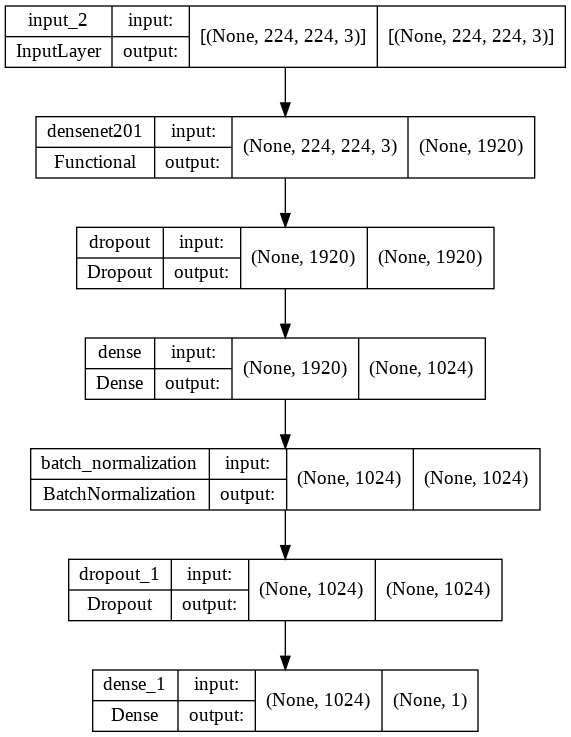

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_cohen_kappa",
                                                  verbose=1,
                                                  patience=5,
                                                  mode="max",
                                                  baseline=0.0,
                                                  restore_best_weights=True)

In [ ]:
history = model.fit(train,
                    epochs=12,
                    validation_data=val,
                    callbacks=[early_stopping],
                    workers=8)

Epoch 1/12
3681/3681 [==============================] - 686s 181ms/step - loss: 0.7005 - binary_acc: 0.6444 - cohen_kappa: 0.2524 - val_loss: 0.5961 - val_binary_acc: 0.6911 - val_cohen_kappa: 0.3240
Epoch 2/12
3681/3681 [==============================] - 641s 174ms/step - loss: 0.6288 - binary_acc: 0.6744 - cohen_kappa: 0.3081 - val_loss: 0.5638 - val_binary_acc: 0.7173 - val_cohen_kappa: 0.3752
Epoch 3/12
3681/3681 [==============================] - 651s 177ms/step - loss: 0.6028 - binary_acc: 0.6836 - cohen_kappa: 0.3246 - val_loss: 0.5454 - val_binary_acc: 0.7292 - val_cohen_kappa: 0.4129
Epoch 4/12
3681/3681 [==============================] - 637s 173ms/step - loss: 0.5891 - binary_acc: 0.6948 - cohen_kappa: 0.3455 - val_loss: 0.5448 - val_binary_acc: 0.7287 - val_cohen_kappa: 0.4267
Epoch 5/12
3681/3681 [==============================] - 643s 175ms/step - loss: 0.5827 - binary_acc: 0.6979 - cohen_kappa: 0.3511 - val_loss: 0.5503 - val_binary_acc: 0.7267 - val_cohen_kappa: 0.3927


In [ ]:
model.save('/content/drive/MyDrive/Dense201')

In [ ]:
kappa = history.history['cohen_kappa']
val_kappa = history.history['val_cohen_kappa']
loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs = range(len(kappa))

plt.figure(figsize = (7,8))

plt.plot(epochs, kappa, 'cyan', label='Training kappa')
plt.plot(epochs, val_kappa, 'plum', label='Validation kappa')
plt.title('Training and validation kappa for DenseNet 121)
plt.legend()

plt.figure()

plt.figure(figsize = (7,8))

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'plum', label='Validation loss')
plt.title('Training and validation loss for DenseNet 121')
plt.legend()

plt.show()

In [ ]:
model_dense201.trainable = True

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.BinaryCrossentropy(),metrics=Metrics)

In [ ]:
history = model.fit(train,
                    epochs=15,
                    validation_data=val,
                    callbacks=[early_stopping, tf.keras.callbacks.ReduceLROnPlateau(
                        monitor='val_cohen_kappa',
                        factor=0.1,
                        patience=8,
                        min_lr=1e-9)],
                    workers=8)

In [ ]:
model.save('/content/drive/MyDrive/Dense201Ultra')

In [ ]:
plt.style.use("bmh")
kappa = history.history['cohen_kappa']
val_kappa = history.history['val_cohen_kappa']
loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs = range(len(kappa))

plt.figure(figsize = (7,8))

plt.plot(epochs, kappa, 'cyan', label='Training kappa')
plt.plot(epochs, val_kappa, 'plum', label='Validation kappa')
plt.title('Training and validation kappa for ResNet 50 (Unfrozen)')
plt.legend()

plt.figure()

plt.figure(figsize = (7,8))

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'plum', label='Validation loss')
plt.title('Training and validation loss for ResNet 50 (Unfrozen)')
plt.legend()

plt.show()

In [ ]:
model.evaluate(test,verbose=1)

In [ ]:
pred=model.predict(test)
pred=np.round(pred)
pred=pd.DataFrame(pred).astype('int')
pred=pred.astype('str')

In [ ]:
mat_aug = confusion_matrix(test_data.label, pred)
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_aug, annot=True, fmt='g', cmap = 'Blues')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('Resnet50 Confusion Matrix')
ax.xaxis.set_ticklabels([i for i in range(0,2)])
ax.yaxis.set_ticklabels([i for i in range(0,2)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
mat_perc = 100*(mat_aug / len(test_data))
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_perc, annot=True, fmt='g', cmap = 'PuBuGn')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('Resnet50 Confusion Matrix')
ax.xaxis.set_ticklabels([i for i in range(0,2)])
ax.yaxis.set_ticklabels([i for i in range(0,2)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print(classification_report(test_data.label, pred))

In [ ]:
wrist_test=test_data[test_data['type']=='XR_WRIST']
wrist_pred=pred[test_data['type']=='XR_WRIST']

shoulder_test=test_data[test_data['type']=='XR_SHOULDER']
shoulder_pred=pred[test_data['type']=='XR_SHOULDER']

elbow_test=test_data[test_data['type']=='XR_ELBOW']
elbow_pred=pred[test_data['type']=='XR_ELBOW']

finger_test=test_data[test_data['type']=='XR_FINGER']
finger_pred=pred[test_data['type']=='XR_FINGER']

hand_test=test_data[test_data['type']=='XR_HAND']
hand_pred=pred[test_data['type']=='XR_HAND']

forearm_test=test_data[test_data['type']=='XR_FOREARM']
forearm_pred=pred[test_data['type']=='XR_FOREARM']

humerus_test=test_data[test_data['type']=='XR_HUMERUS']
humerus_pred=pred[test_data['type']=='XR_HUMERUS']

In [ ]:
print('Cohen kappa score for wrist:',cohen_kappa_score(wrist_test.label,wrist_pred))
print('Cohen kappa score for shoulder:',cohen_kappa_score(shoulder_test.label,shoulder_pred))
print('Cohen kappa score for elbow:',cohen_kappa_score(elbow_test.label,elbow_pred))
print('Cohen kappa score for finger:',cohen_kappa_score(finger_test.label,finger_pred))
print('Cohen kappa score for hand:',cohen_kappa_score(hand_test.label,hand_pred))
print('Cohen kappa score for forearm:',cohen_kappa_score(forearm_test.label,forearm_pred))
print('Cohen kappa score for humerus:',cohen_kappa_score(humerus_test.label,humerus_pred))